# Predicting Gene Sequence Regenerative Contributions 

By: Jaeyoon Jung, Jeremy Milford, Shree Patel, Cynthia Perez

This notebook develops a model from gene sequences of the axolotl and zebrafish, model regenerative species. This notebook uses feature engineered data to run gridsearch, PCA, and maps the gene data to amino acid sequences to explore biological implications. 

### Necessary Imports

In [1]:
# necessary imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import tensorflow as tf
from tensorflow import keras 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Reshape, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from scipy.stats import ttest_ind
from onehot import onehote

2024-12-09 23:30:06.279280: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.threading.set_intra_op_parallelism_threads(2)  # Adjust as needed
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.set_visible_devices([], 'GPU')

Num GPUs Available:  0


In [4]:
features_df = pd.read_csv("gene_sequences.csv")
features_df.head()

,gene_name,sequence_length,gc_content,at_gc_ratio,kmer_3_GGG,kmer_3_GGC,kmer_3_GCG,kmer_3_CGG,kmer_3_GCT,kmer_3_CTG,...,kmer_3_TAG,kmer_3_CAN,kmer_3_ANN,kmer_3_NNN,kmer_3_NNT,kmer_3_NTA,organism,chromosome,regen,sequence
0,ADIPOQ,1487,0.465367,1.148844,0.014141,0.016162,0.005387,0.005387,0.013468,0.022896,...,0.008754,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,2,0,CTCAGGAGACCTGGCGATTTTCTCTTCATTCCTGTCTGTACGAGTG...
1,AGTR1A,2286,0.463255,1.158640,0.007881,0.018827,0.005692,0.004378,0.022329,0.029335,...,0.007881,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,2,0,CCGAGCCTGAGGGTTGGAACCTGCAGAGCAGCGACGCCCCCTAGGC...
2,AGTR2,2861,0.386928,1.584463,0.008395,0.010843,0.001399,0.001749,0.015390,0.023435,...,0.011193,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,2,0,CCAGAGTCTGGGGATGGAGCGAGCACAGAATTGAAAGCTTTCTTCA...
3,AMTN,1032,0.465116,1.150000,0.011650,0.013592,0.001942,0.001942,0.014563,0.025243,...,0.005825,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,X2,1,AAAAGATAAATTTTGCACCAGAGTAAAGTGGAGAAGTCATCTGGAT...
4,ARHGDIA,89866,0.470211,1.126704,0.016681,0.013810,0.006310,0.007344,0.015112,0.021421,...,0.011440,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,3q,0,TTTCTAGAGCTCTCTTGTGGGACGGGAACTAGATAGACCGGAACTA...


### Test, Train Split

In [5]:
# Drop gene_name and separate features and target 
X = features_df.drop(columns=['gene_name'])
y = (features_df['regen']).astype(int)  
y = y.to_numpy()

# Choose only numeric features for modeling
X_col = X.columns
print(X_col)
X_numeric_features = ["sequence_length", "gc_content", "at_gc_ratio", 'kmer_3_GGG',
       'kmer_3_GGC', 'kmer_3_GCG', 'kmer_3_CGG', 'kmer_3_GCT', 'kmer_3_CTG',
       'kmer_3_TGC', 'kmer_3_GCC', 'kmer_3_CCG', 'kmer_3_CGC', 'kmer_3_CCA',
       'kmer_3_CAG', 'kmer_3_AGC', 'kmer_3_CCC', 'kmer_3_CTA', 'kmer_3_TAA',
       'kmer_3_AAG', 'kmer_3_AGG', 'kmer_3_CTC', 'kmer_3_TCG', 'kmer_3_GGA',
       'kmer_3_GAG', 'kmer_3_AGA', 'kmer_3_TCT', 'kmer_3_TGT', 'kmer_3_GTT',
       'kmer_3_TTT', 'kmer_3_TTC', 'kmer_3_TCC', 'kmer_3_AGT', 'kmer_3_GTC',
       'kmer_3_GTG', 'kmer_3_TGG', 'kmer_3_CTT', 'kmer_3_TTA', 'kmer_3_AAA',
       'kmer_3_CAC', 'kmer_3_ACT', 'kmer_3_CGT', 'kmer_3_CAA', 'kmer_3_AAT',
       'kmer_3_ATG', 'kmer_3_TAT', 'kmer_3_TGA', 'kmer_3_GAC', 'kmer_3_ACA',
       'kmer_3_TCA', 'kmer_3_CCT', 'kmer_3_ACG', 'kmer_3_GAT', 'kmer_3_ATC',
       'kmer_3_CGA', 'kmer_3_CAT', 'kmer_3_TAC', 'kmer_3_AAC', 'kmer_3_GCA',
       'kmer_3_GAA', 'kmer_3_ACC', 'kmer_3_GGT', 'kmer_3_ATT', 'kmer_3_TTG',
       'kmer_3_ATA', 'kmer_3_GTA', 'kmer_3_TAG', 'kmer_3_CAN', 'kmer_3_ANN',
       'kmer_3_NNN', 'kmer_3_NNT', 'kmer_3_NTA']

X = X.drop(columns = X_numeric_features)
X.head()


Index(['sequence_length', 'gc_content', 'at_gc_ratio', 'kmer_3_GGG',
       'kmer_3_GGC', 'kmer_3_GCG', 'kmer_3_CGG', 'kmer_3_GCT', 'kmer_3_CTG',
       'kmer_3_TGC', 'kmer_3_GCC', 'kmer_3_CCG', 'kmer_3_CGC', 'kmer_3_CCA',
       'kmer_3_CAG', 'kmer_3_AGC', 'kmer_3_CCC', 'kmer_3_CTA', 'kmer_3_TAA',
       'kmer_3_AAG', 'kmer_3_AGG', 'kmer_3_CTC', 'kmer_3_TCG', 'kmer_3_GGA',
       'kmer_3_GAG', 'kmer_3_AGA', 'kmer_3_TCT', 'kmer_3_TGT', 'kmer_3_GTT',
       'kmer_3_TTT', 'kmer_3_TTC', 'kmer_3_TCC', 'kmer_3_AGT', 'kmer_3_GTC',
       'kmer_3_GTG', 'kmer_3_TGG', 'kmer_3_CTT', 'kmer_3_TTA', 'kmer_3_AAA',
       'kmer_3_CAC', 'kmer_3_ACT', 'kmer_3_CGT', 'kmer_3_CAA', 'kmer_3_AAT',
       'kmer_3_ATG', 'kmer_3_TAT', 'kmer_3_TGA', 'kmer_3_GAC', 'kmer_3_ACA',
       'kmer_3_TCA', 'kmer_3_CCT', 'kmer_3_ACG', 'kmer_3_GAT', 'kmer_3_ATC',
       'kmer_3_CGA', 'kmer_3_CAT', 'kmer_3_TAC', 'kmer_3_AAC', 'kmer_3_GCA',
       'kmer_3_GAA', 'kmer_3_ACC', 'kmer_3_GGT', 'kmer_3_ATT', 'kmer_3_TTG',
       

,organism,chromosome,regen,sequence
0,Rattus norvegicus,2,0,CTCAGGAGACCTGGCGATTTTCTCTTCATTCCTGTCTGTACGAGTG...
1,Rattus norvegicus,2,0,CCGAGCCTGAGGGTTGGAACCTGCAGAGCAGCGACGCCCCCTAGGC...
2,Rattus norvegicus,2,0,CCAGAGTCTGGGGATGGAGCGAGCACAGAATTGAAAGCTTTCTTCA...
3,Rattus norvegicus,X2,1,AAAAGATAAATTTTGCACCAGAGTAAAGTGGAGAAGTCATCTGGAT...
4,Ambystoma mexicanum,3q,0,TTTCTAGAGCTCTCTTGTGGGACGGGAACTAGATAGACCGGAACTA...


In [6]:
# one hot encode each sequence and store in a NumPy array
sequences_ohe = []
for seq in X['sequence']:
    output = onehote(seq)
    if output is None:
        continue
    else:
        sequences_ohe.append(output)

# Pad sequences so they have the same length, but without truncation.
sequences_ohe_padded = pad_sequences(sequences_ohe, padding='post', dtype='float32', value=0)

This train, test split has considered only the numerical features of the data (i.e. no information on organism or chromosome location of the gene)

### CNN on Feature DataFrame

In [7]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (validation loss in this case)
    patience=3,             # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history = model.fit(
    sequences_ohe_padded, y,
    epochs=50,                 # Maximum number of epochs
    batch_size=16,
    validation_split = 0.2,
    callbacks=[early_stopping])  # Add the EarlyStopping callback here

2024-12-09 23:31:10.579631: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4360711712 exceeds 10% of free system memory.


Epoch 1/50


2024-12-09 23:31:24.888874: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4730259456 exceeds 10% of free system memory.


: 

The parameters for this CNN were chosen based on our previous trials in model development. We are seeing early stoppage. Let us consider altering the parameters we are using through GridSearch

### Gridsearch to Improve CNN

In [5]:
# Define a Model Builder
def build_model(optimizer='adam', dropout_rate=0.3):
    model = Sequential([
    Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(dropout_rate),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',     # Metric to monitor (validation loss in this case)
        patience=3,             # Number of epochs with no improvement after which training stops
        restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
    )

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# ~20 min run time

model = KerasClassifier(build_fn=build_model, verbose=0, dropout_rate=0.2)

param_grid = {
    'optimizer': ['adam', 'rmsprop'],  # Optimizer choices
    'dropout_rate': [0.2, 0.3, 0.5],  # Dropout rate options
    'batch_size': [16, 32, 64],  # Batch size options
    'epochs': [10, 20, 50]  # Number of epochs to train for
}

# Initialize GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0)

# Fit the GridSearchCV to the training data
grid_result = grid.fit(X_train, Y_train)

/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py

/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py

### Un-altered Data with Gridsearch Evaluation

Best: 0.614103 using {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 10, 'optimizer': 'adam'}
Epoch 1/10


/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.4502 - loss: 0.6966 - val_accuracy: 0.6667 - val_loss: 0.6864
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5278 - loss: 0.6882 - val_accuracy: 0.4583 - val_loss: 0.6901
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5354 - loss: 0.6792 - val_accuracy: 0.4167 - val_loss: 0.6902
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6045 - loss: 0.6740 - val_accuracy: 0.3750 - val_loss: 0.6977
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5120 - loss: 0.6867 - val_accuracy: 0.4167 - val_loss: 0.6930
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5695 - loss: 0.6812 - val_accuracy: 0.5000 - val_loss: 0.6873
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6217 - loss: 0.6664 - val_accuracy: 0.5000 - val_loss: 0.6846
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5760 - loss: 0.6608 - val_accuracy: 0.5000 - val_loss: 0.6862
Epoch 9/10

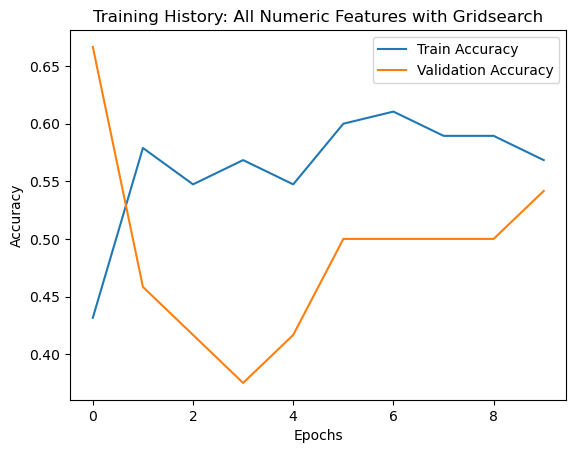

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


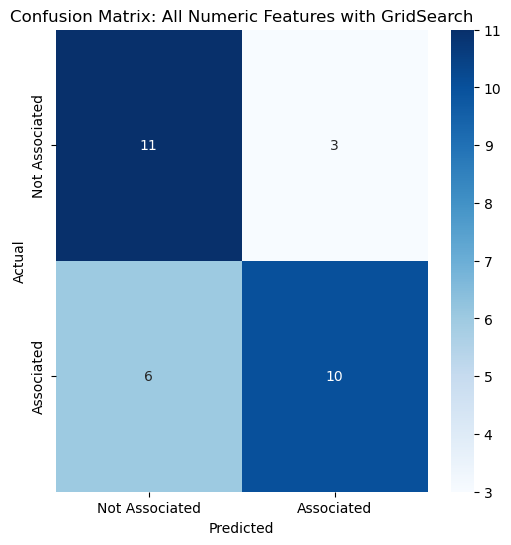

                precision    recall  f1-score   support

Not Associated       0.65      0.79      0.71        14
    Associated       0.77      0.62      0.69        16

      accuracy                           0.70        30
     macro avg       0.71      0.71      0.70        30
  weighted avg       0.71      0.70      0.70        30

Test Accuracy: 0.7


In [7]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Use the best model to make predictions
best_model = grid_result.best_params_
# Create the model using the best parameters
model = build_model(dropout_rate=best_model['dropout_rate'],
                     optimizer=best_model['optimizer'])

# Fit the model and get the history
history = model.fit(X_train, Y_train, epochs=best_model['epochs'], batch_size=best_model['batch_size'], validation_split=0.2)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training History: All Numeric Features with Gridsearch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(Y_test, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.title("Confusion Matrix: All Numeric Features with GridSearch")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(Y_test, y_pred_binary, target_names=["Not Associated", "Associated"]))

print("Test Accuracy:", accuracy_score(Y_test, y_pred_binary))

Let us also try PCA and see if the results are improved by using PCA. We shall run the model withour gridsearch first, then we will consider running gridsearch on a smaller set of parameters based on the best ones chosen by the non-PCA run 

### PCA

In [8]:
# define my PCA function

def apply_pca(X_train, X_test, n_components=5):
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    print("Explained variance by PCA components:", pca.explained_variance_ratio_)
    return X_train, X_test, pca.explained_variance_ratio_, pca

Explained variance by PCA components: [0.30634315 0.1178187  0.10326074 0.09376462]


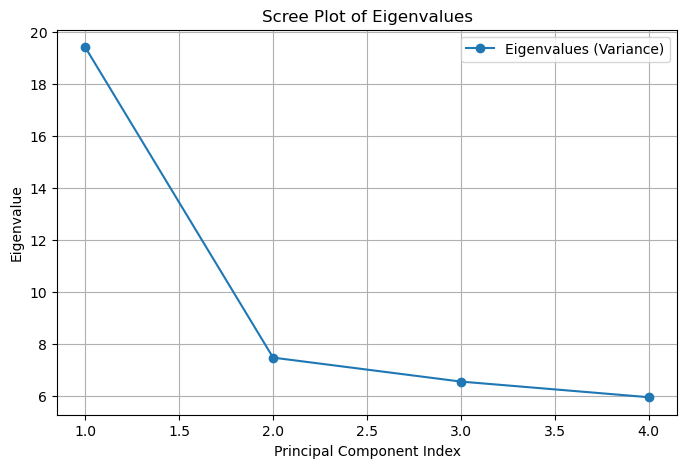

In [9]:
X_train_PCA, X_test_PCA, var_ratio, pca_obj = apply_pca(X_train, X_test, n_components=4)

#Plotting the cumulative variance
eigenvalues = pca_obj.explained_variance_

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', label='Eigenvalues (Variance)')
plt.title("Scree Plot of Eigenvalues")
plt.xlabel("Principal Component Index")
plt.ylabel("Eigenvalue")
plt.grid()
plt.legend()
plt.show()

We have tried running the model with PCA from 3-6 components, we found 4 works best. We will use 4 features for the modeling work onwards. Let's use the best features we discovered from the last model

In [10]:
model = Sequential([
    Reshape((X_train_PCA.shape[1], 1), input_shape=(X_train_PCA.shape[1],)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (validation loss in this case)
    patience=3,             # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history = model.fit(
    X_train_PCA, Y_train,
    epochs=50,                 # Maximum number of epochs
    batch_size=16,
    validation_data=(X_test_PCA, Y_test),
    callbacks=[early_stopping])  # Add the EarlyStopping callback here

Epoch 1/50


/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5686 - loss: 0.6772 - val_accuracy: 0.6667 - val_loss: 0.6453
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5939 - loss: 0.6717 - val_accuracy: 0.6667 - val_loss: 0.6329
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6575 - loss: 0.6572 - val_accuracy: 0.7000 - val_loss: 0.6216
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5855 - loss: 0.6568 - val_accuracy: 0.7000 - val_loss: 0.6175
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6956 - loss: 0.6201 - val_accuracy: 0.7000 - val_loss: 0.6153
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6342 - loss: 0.6407 - val_accuracy: 0.7000 - val_loss: 0.6129
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6586 - loss: 0.6094 - val_accuracy: 0.7000 - val_loss: 0.6126
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5834 - loss: 0.6292 - val_accuracy: 0.6667 - val_loss: 0.6138
Epoch 9/50
8/8 ━━━

Note: we encounter early stoppage, but our results seem to be better than the last model

### PCA with CNN Evaluation

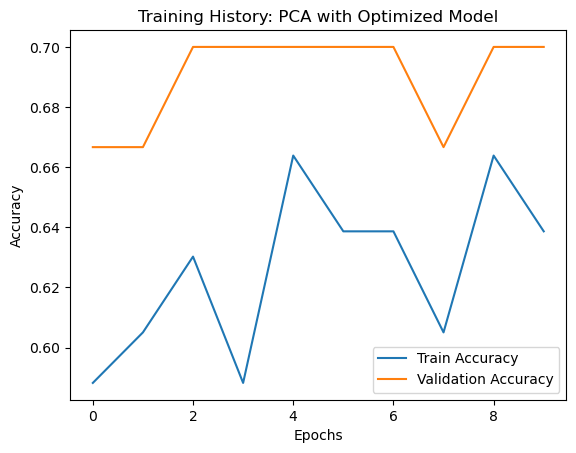

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


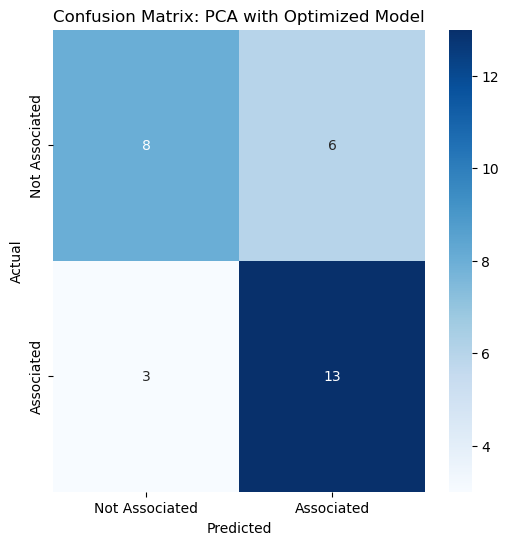

                precision    recall  f1-score   support

Not Associated       0.73      0.57      0.64        14
    Associated       0.68      0.81      0.74        16

      accuracy                           0.70        30
     macro avg       0.71      0.69      0.69        30
  weighted avg       0.70      0.70      0.69        30

Test Accuracy: 0.7


In [11]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training History: PCA with Optimized Model")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred = model.predict(X_test_PCA)
y_pred_binary = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(Y_test, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.title("Confusion Matrix: PCA with Optimized Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(Y_test, y_pred_binary, target_names=["Not Associated", "Associated"]))

print("Test Accuracy:", accuracy_score(Y_test, y_pred_binary))

Okay, we are receiving decent results. Let us try gridsearch as well to see if the accuracy will improve

### PCA with GridSearch CNN

In [12]:
def build_model(optimizer='adam', dropout_rate=0.3):
    model = Sequential([
    Reshape((X_train_PCA.shape[1], 1), input_shape=(X_train_PCA.shape[1],)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(dropout_rate),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',     # Metric to monitor (validation loss in this case)
        patience=3,             # Number of epochs with no improvement after which training stops
        restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
    )

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
model = KerasClassifier(build_fn=build_model, verbose=0, dropout_rate=0.2)

param_grid = {
    'optimizer': ['adam', 'rmsprop'],  # Optimizer choices
    'dropout_rate': [0.2, 0.3, 0.5],  # Dropout rate options
    'batch_size': [16, 32, 64],  # Batch size options
    'epochs': [20, 30, 50]  # Number of epochs to train for
}

# Initialize GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0)

# Fit the GridSearchCV to the training data
grid_result = grid.fit(X_train_PCA, Y_train)

/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py

Best: 0.613675 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'optimizer': 'rmsprop'}
Epoch 1/20


/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5329 - loss: 0.6894 - val_accuracy: 0.5833 - val_loss: 0.6846
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6792 - loss: 0.6766 - val_accuracy: 0.6250 - val_loss: 0.6801
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6662 - loss: 0.6719 - val_accuracy: 0.5833 - val_loss: 0.6785
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6780 - loss: 0.6584 - val_accuracy: 0.5833 - val_loss: 0.6751
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6714 - loss: 0.6472 - val_accuracy: 0.5833 - val_loss: 0.6725
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6898 - loss: 0.6472 - val_accuracy: 0.5833 - val_loss: 0.6763
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6650 - loss: 0.6379 - val_accuracy: 0.5833 - val_loss: 0.6765
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6714 - loss: 0.6300 - val_accuracy: 0.5833 - val_loss: 0.6791
Epoch 9/20


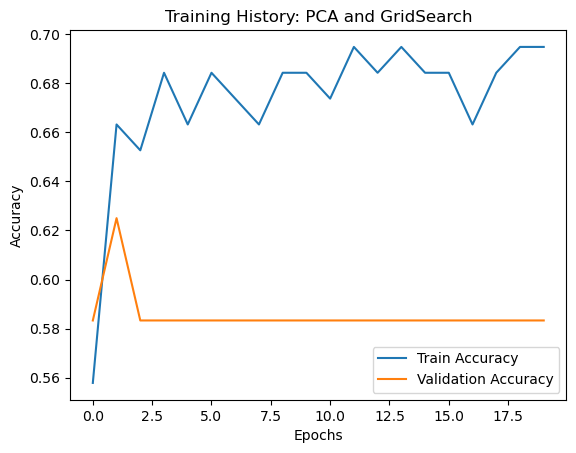

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


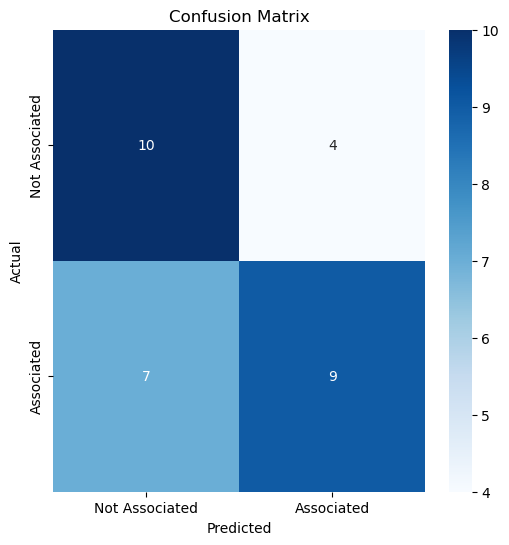

                precision    recall  f1-score   support

Not Associated       0.59      0.71      0.65        14
    Associated       0.69      0.56      0.62        16

      accuracy                           0.63        30
     macro avg       0.64      0.64      0.63        30
  weighted avg       0.64      0.63      0.63        30

Test Accuracy: 0.6333333333333333


In [14]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Use the best model to make predictions
best_model = grid_result.best_params_
# Create the model using the best parameters
model = build_model(dropout_rate=best_model['dropout_rate'],
                     optimizer=best_model['optimizer'])

# Fit the model and get the history
history = model.fit(X_train_PCA, Y_train, epochs=20, batch_size=32, validation_split=0.2)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training History: PCA and GridSearch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred = model.predict(X_test_PCA)
y_pred_binary = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(Y_test, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.title("Confusion Matrix: PCA and GridSearch")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(Y_test, y_pred_binary, target_names=["Not Associated", "Associated"]))

print("Test Accuracy:", accuracy_score(Y_test, y_pred_binary))

We've modeled our dataset with a wide variety of techniques. Let us see what this means contextualized with biology